In [1]:
! pip install Faker




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.9 MB/s eta 0:00:00


In [2]:
# Notebook: generate_large_healthcare_datasets.ipynb

import pandas as pd
import numpy as np
import random
from faker import Faker

fake = Faker()

# --------------------------
# Generate Large EMR Dataset
# --------------------------
num_patients = 10000

patient_ids = [f"P{100000+i}" for i in range(num_patients)]
ages = np.random.randint(0, 90, num_patients)
genders = np.random.choice(['Male', 'Female', 'Other'], num_patients, p=[0.48,0.48,0.04])
visit_dates = [fake.date_between(start_date='-3y', end_date='today') for _ in range(num_patients)]
diagnosis_codes = np.random.choice(['D01','D02','D03','D04','D05','D06','D07'], num_patients)
medications = np.random.choice(['MedA','MedB','MedC','MedD','MedE','MedF'], num_patients)

emr_df = pd.DataFrame({
    'patient_id': patient_ids,
    'age': ages,
    'gender': genders,
    'visit_date': visit_dates,
    'diagnosis_code': diagnosis_codes,
    'medication': medications
})

# --------------------------
# Generate Large Claims Dataset
# --------------------------
num_claims = 20000

claim_ids = [f"C{200000+i}" for i in range(num_claims)]
claim_patient_ids = np.random.choice(patient_ids, num_claims)
procedure_codes = np.random.choice(['P001','P002','P003','P004','P005'], num_claims)
claim_amounts = np.round(np.random.uniform(50, 10000, num_claims), 2)
provider_ids = [f"PR{random.randint(100,299)}" for _ in range(num_claims)]
claim_dates = [fake.date_between(start_date='-3y', end_date='today') for _ in range(num_claims)]

claims_df = pd.DataFrame({
    'claim_id': claim_ids,
    'patient_id': claim_patient_ids,
    'procedure_code': procedure_codes,
    'claim_amount': claim_amounts,
    'provider_id': provider_ids,
    'claim_date': claim_dates
})

# --------------------------
# Generate Large Lab Results Dataset
# --------------------------
num_labs = 15000

lab_ids = [f"L{300000+i}" for i in range(num_labs)]
lab_patient_ids = np.random.choice(patient_ids, num_labs)
test_types = np.random.choice(['Blood','Urine','X-Ray','MRI','CT Scan','Ultrasound'], num_labs)
test_values = np.round(np.random.normal(100, 20, num_labs),2)
reference_ranges = ['80-120']*num_labs
test_dates = [fake.date_between(start_date='-3y', end_date='today') for _ in range(num_labs)]

labs_df = pd.DataFrame({
    'lab_id': lab_ids,
    'patient_id': lab_patient_ids,
    'test_type': test_types,
    'test_value': test_values,
    'reference_range': reference_ranges,
    'test_date': test_dates
})

# --------------------------
# Save to CSV
# --------------------------
emr_df.to_csv('emr_data_large.csv', index=False)
claims_df.to_csv('claims_data_large.csv', index=False)
labs_df.to_csv('lab_results_large.csv', index=False)

print("Large healthcare datasets generated and saved as CSVs.")


Large healthcare datasets generated and saved as CSVs.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.6 MB/s eta 0:00:00


EMR dataset: (10000, 6)
Claims dataset: (20000, 6)
Labs dataset: (15000, 6)

--- EMR Dataset ---
Missing Values:
 patient_id        0
age               0
gender            0
visit_date        0
diagnosis_code    0
medication        0
dtype: int64
Duplicate Rows: 0
Data Types:
 patient_id        object
age                int64
gender            object
visit_date        object
diagnosis_code    object
medication        object
dtype: object
Summary Stats:
                 age
count  10000.000000
mean      44.197800
std       25.854886
min        0.000000
25%       22.000000
50%       44.000000
75%       67.000000
max       89.000000

--- Claims Dataset ---
Missing Values:
 claim_id          0
patient_id        0
procedure_code    0
claim_amount      0
provider_id       0
claim_date        0
dtype: int64
Duplicate Rows: 0
Data Types:
 claim_id           object
patient_id         object
procedure_code     object
claim_amount      float64
provider_id        object
claim_date         object
d

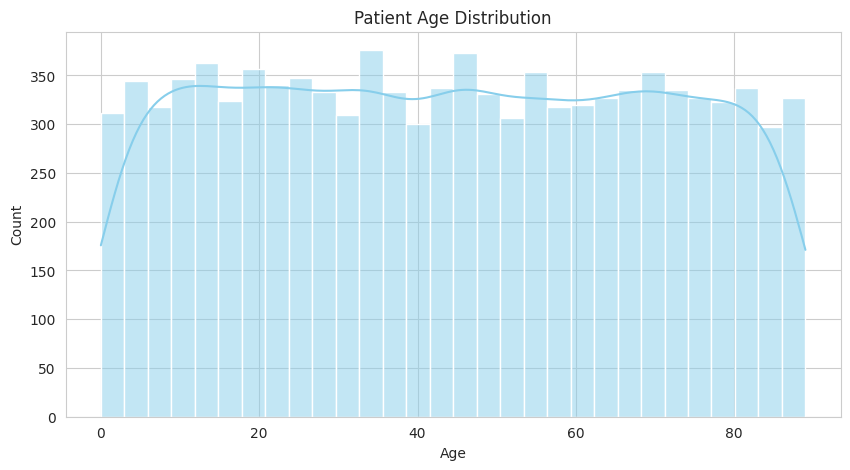

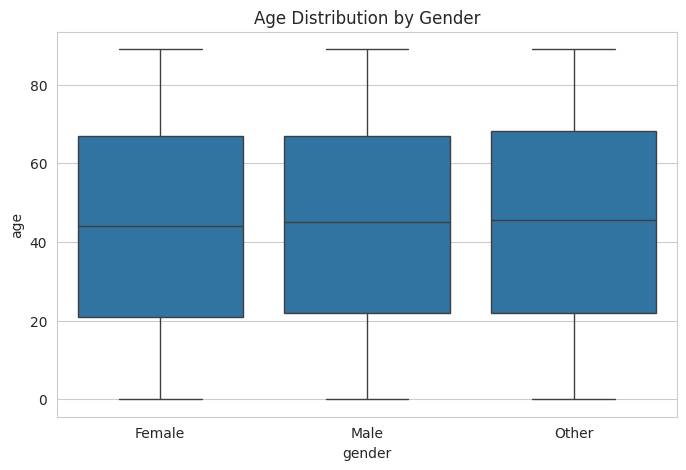

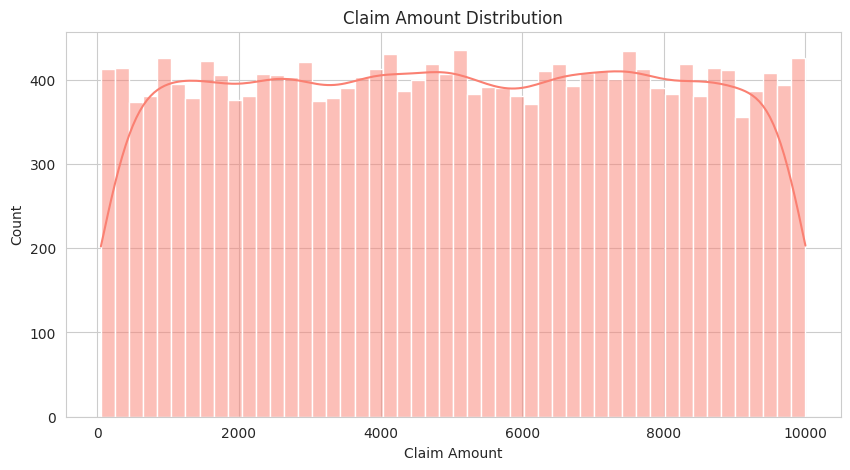

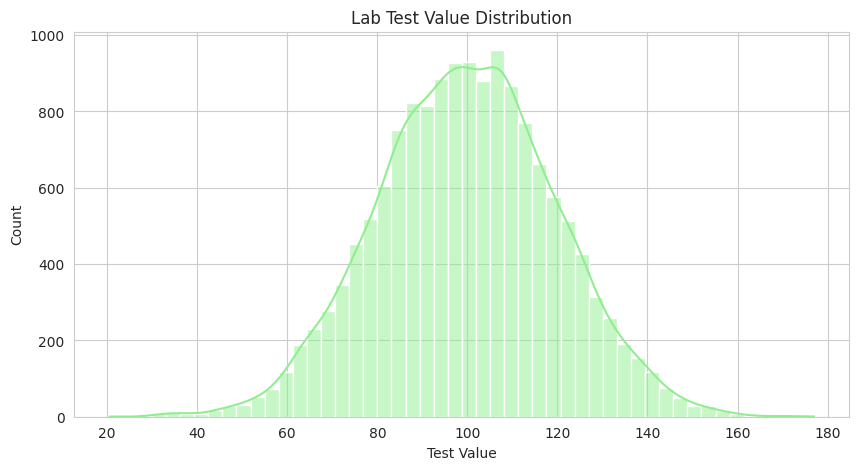


--- Data Quality Summary ---
EMR: 10000 records, 0 duplicates
Claims: 20000 records, 6649 duplicate entries
Patients with claims but no EMR record: 0
Labs: 15000 records, 4663 anomalies detected


In [3]:
# Large-scale Healthcare Data Quality Analysis (Python-only, Fixed Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Load Large Datasets
# --------------------------
emr_df = pd.read_csv('emr_data_large.csv')
claims_df = pd.read_csv('claims_data_large.csv')
labs_df = pd.read_csv('lab_results_large.csv')

print(f"EMR dataset: {emr_df.shape}")
print(f"Claims dataset: {claims_df.shape}")
print(f"Labs dataset: {labs_df.shape}")

# --------------------------
# Basic Data Quality Checks
# --------------------------
def data_quality_summary(df, name):
    print(f"\n--- {name} Dataset ---")
    print("Missing Values:\n", df.isnull().sum())
    print("Duplicate Rows:", df.duplicated().sum())
    print("Data Types:\n", df.dtypes)
    print("Summary Stats:\n", df.describe())

data_quality_summary(emr_df, "EMR")
data_quality_summary(claims_df, "Claims")
data_quality_summary(labs_df, "Labs")

# --------------------------
# Python-only Validations
# --------------------------

# 1. Patients with claims but no EMR record
claims_only_patients = set(claims_df['patient_id']) - set(emr_df['patient_id'])
claims_only_df = claims_df[claims_df['patient_id'].isin(claims_only_patients)]
claims_only_count = claims_only_df.shape[0]

# 2. Duplicate claims per patient & procedure
duplicate_claims_df = claims_df.groupby(['patient_id','procedure_code']).filter(lambda x: len(x) > 1)
duplicate_count = duplicate_claims_df.shape[0] if not duplicate_claims_df.empty else 0

# 3. Lab anomalies outside reference range
labs_df[['low_ref','high_ref']] = labs_df['reference_range'].str.split(pat='-', n=1, expand=True).astype(float)
lab_anomalies_df = labs_df[(labs_df['test_value'] < labs_df['low_ref']) | (labs_df['test_value'] > labs_df['high_ref'])]
anomaly_count = lab_anomalies_df.shape[0] if not lab_anomalies_df.empty else 0

# --------------------------
# Visualizations
# --------------------------
sns.set_style("whitegrid")

# Patient Age Distribution
plt.figure(figsize=(10,5))
sns.histplot(emr_df['age'], bins=30, kde=True, color='skyblue')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Gender vs Age Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='gender', y='age', data=emr_df)
plt.title("Age Distribution by Gender")
plt.show()

# Claim Amount Distribution
plt.figure(figsize=(10,5))
sns.histplot(claims_df['claim_amount'], bins=50, kde=True, color='salmon')
plt.title("Claim Amount Distribution")
plt.xlabel("Claim Amount")
plt.ylabel("Count")
plt.show()

# Lab Test Value Distribution
plt.figure(figsize=(10,5))
sns.histplot(labs_df['test_value'], bins=50, kde=True, color='lightgreen')
plt.title("Lab Test Value Distribution")
plt.xlabel("Test Value")
plt.ylabel("Count")
plt.show()

# --------------------------
# Final Data Quality Summary (Safe)
# --------------------------
print("\n--- Data Quality Summary ---")
print(f"EMR: {emr_df.shape[0]} records, {emr_df.duplicated().sum()} duplicates")
print(f"Claims: {claims_df.shape[0]} records, {duplicate_count} duplicate entries")
print(f"Patients with claims but no EMR record: {claims_only_count}")
print(f"Labs: {labs_df.shape[0]} records, {anomaly_count} anomalies detected")